In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import datajoint as dj
import static_nda as nda
from stimulus import stimulus
stats = dj.create_virtual_module('neurodata_static_stats', 'neurodata_static_stats')

Loading local settings from pipeline_config.json
Connecting pfahey@at-database.ad.bcm.edu:3306


In [2]:
# scan_keys = nda.Scan # scans considered for release, including duplicates
scan_keys = nda.ScanInclude # scans included in release

# Stimulus Design

In [3]:
print('mix of stimulus.Frame and stimulus.Clip')
dj.U('stimulus_type').aggr(dj.U('condition_hash','stimulus_type') & 
                           (stimulus.Condition * (stimulus.Trial & scan_keys)),
                           num_conditions='count(*)')

all_ids = dj.U('image_class','image_id').aggr((stimulus.Trial & scan_keys)*stimulus.Frame,
                                             n_total='count(*)',
                                             min_animal='MIN(animal_id)',
                                             min_scan = 'MIN(scan_idx)', 
                                             min_session = 'MIN(session)')
all_ids = dj.U('image_id','n_total','min_animal','min_scan','min_session') & all_ids


print('\nall one presentation time: ',
      (dj.U('presentation_time') & (stimulus.Frame * (stimulus.Trial & scan_keys))).fetch1('presentation_time'),
      ' sec')

print('\nall one image class: ',
      (dj.U('image_class') & (stimulus.Frame * (stimulus.Trial & scan_keys))).fetch1('image_class'))

print('\ntotal unique images: ', len(dj.U('image_class','image_id') & \
                                     (stimulus.Frame * (stimulus.Trial & scan_keys))))


mix of stimulus.Frame and stimulus.Clip

all one presentation time:  0.5  sec

all one image class:  imagenet

total unique images:  20200


# Single Scan Composition

In [4]:
repeat_df = []
for scan in scan_keys.proj():
    scan_str = '_'.join([str(s) for s in scan.values()])
    
    scan_hashes = stimulus.Condition * dj.U('condition_hash').aggr(stimulus.Trial & scan,n_repeats='count(*)')
    hash_repeats = dj.U('stimulus_type','n_repeats').aggr(scan_hashes,n_hashes='count(*)')
    repeat_str = ', '.join([str(d['n_repeats'])+'x '+ 
                            d['stimulus_type'].replace('stimulus.','') + ': ' + 
                            str(d['n_hashes']) 
                            for d in hash_repeats.fetch(as_dict=True)])
    
    repeat_df.append({'scan':scan_str,'repeats':repeat_str})
    
repeat_df = pd.DataFrame(repeat_df)
display(repeat_df.groupby('repeats').count())
display(repeat_df)


,scan
repeats,
"1x Frame: 5000, 10x Frame: 100",5
"9x Clip: 6, 1x Frame: 5000, 10x Frame: 200",2


,scan,repeats
0,21067_10_18,"1x Frame: 5000, 10x Frame: 100"
1,22846_10_16,"1x Frame: 5000, 10x Frame: 100"
2,23343_5_17,"1x Frame: 5000, 10x Frame: 100"
3,23656_14_22,"1x Frame: 5000, 10x Frame: 100"
4,23964_4_22,"1x Frame: 5000, 10x Frame: 100"
5,26644_14_17,"9x Clip: 6, 1x Frame: 5000, 10x Frame: 200"
6,26645_2_18,"9x Clip: 6, 1x Frame: 5000, 10x Frame: 200"


# Oracle Frames (10x)

In [5]:
all_trials = (stimulus.Trial & scan_keys)

intrascan_rel = dj.U('animal_id','session','scan_idx','image_id').aggr(all_trials*stimulus.Frame,
                                                                       intrascan_repeats='count(*)')
interscan_rel = dj.U('image_id').aggr(intrascan_rel & 'intrascan_repeats=10',interscan_repeats = 'count(*)')
display(dj.U('interscan_repeats').aggr(interscan_rel,scan_count='count(*)'))

print('100 unique image ids are repeated 10x in each of 9 scans')
print('\nan additional 100 unique image ids are repeated 10x in 2 scans')

display(dj.U('image_id','pre_blank_period').aggr((all_trials * stimulus.Frame) & 
                                         (interscan_rel & 'interscan_repeats=9').proj(),n_delays='count(*)'))

print('not all pre_blank periods are unique')

interscan_repeats calculated attribute,scan_count calculated attribute
2,100
7,100


100 unique image ids are repeated 10x in each of 9 scans

an additional 100 unique image ids are repeated 10x in 2 scans


image_id image id,pre_blank_period (s) off duration,n_delays calculated attribute


not all pre_blank periods are unique


# Unique Frames (1x)

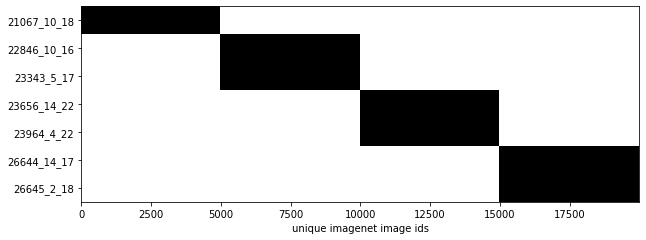

In [10]:
all_1x_ids = all_ids & (dj.U('image_id') & (intrascan_rel & 'intrascan_repeats=1').proj())
all_10x_ids = all_ids & (dj.U('image_id') & (intrascan_rel & 'intrascan_repeats=10').proj())

hash_presence = []

ordered_scan_keys = [{'animal_id': 21067, 'session': 10, 'scan_idx': 18},
                     {'animal_id': 22846, 'session': 10, 'scan_idx': 16},
                     {'animal_id': 23964, 'session': 4, 'scan_idx': 22},
                     {'animal_id': 23343, 'session': 5, 'scan_idx': 17},
                     {'animal_id': 23656, 'session': 14, 'scan_idx': 22},
                     {'animal_id': 26644, 'session': 14, 'scan_idx': 17},
                     {'animal_id': 26645, 'session': 2, 'scan_idx': 18}]

for scan in ordered_scan_keys:
    scan_1x_hashes = (all_1x_ids.aggr(dj.U('trial_idx','image_id') & ((stimulus.Trial & scan) * stimulus.Frame),
                                   n_scan = 'count(trial_idx)',
                                   keep_all_rows=True)).fetch('n_scan',
                                   order_by='min_animal ASC, n_total DESC, min_scan ASC, min_session ASC')
    scan_10x_hashes = (all_10x_ids.aggr(dj.U('trial_idx','image_id') & ((stimulus.Trial & scan) * stimulus.Frame),
                                   n_scan = 'count(trial_idx)',
                                   keep_all_rows=True)).fetch('n_scan',
                                   order_by='min_animal ASC, n_total DESC, min_scan ASC, min_session ASC')
    
    hash_presence.append({'scan_key':scan,'hash_1x_presence':scan_1x_hashes,'hash_10x_presence':scan_10x_hashes})

fig,ax = plt.subplots(figsize=(10,10))

# hash_im = np.hstack((np.vstack([s['hash_10x_presence'] for s in hash_presence])>0,
#                      np.vstack([s['hash_1x_presence'] for s in hash_presence])>0))

hash_im = np.vstack([s['hash_1x_presence'] for s in hash_presence])>0
ax.imshow(hash_im,cmap='binary',interpolation='none')
ax.set_aspect(1000)

ax.set_xlabel('unique imagenet image ids')
ax.set_yticks(np.arange(len(list(scan_keys))))
_ = ax.set_yticklabels(['_'.join([str(s) for s in list(key.values())[:3]]) for key in scan_keys])
for spine in ax.spines.values():
    spine.set_visible('False')
    
plt.show()
plt.close()



# Oracle Scores

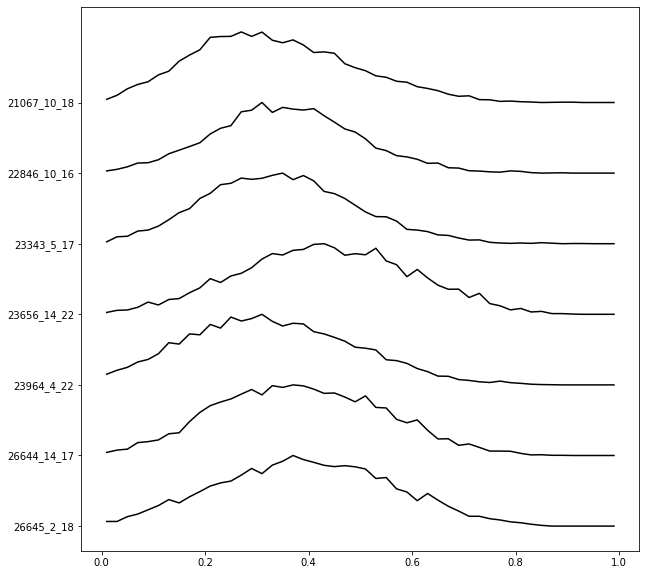

In [7]:
pearsons = []
scan_strs = []

for scan in scan_keys:
    if scan['animal_id'] == 23964:
        scan.update({'group_id':163})
    scan_strs.append('_'.join([str(s) for s in [scan['animal_id'],scan['session'],scan['scan_idx']]]))
    pearsons.append((stats.Oracle.UnitScores & scan).fetch('pearson'))

bins = np.linspace(0,1,51)
bin_cents = np.mean(np.vstack((bins[:-1],bins[1:])),axis=0)
fig,ax = plt.subplots(figsize=(10,10))
for i,pearson in enumerate(pearsons):
    hist, _ = np.histogram(pearson,bins=bins)
    ax.plot(bin_cents,hist/np.max(hist)-i,c='k')
ax.set_yticks(0-np.arange(len(pearsons)))
_ = ax.set_yticklabels(scan_strs)
